In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [42]:
# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

### Load and Verify Data

In [43]:
data = pd.read_csv('data-2.csv.gz')
print(f"Data loaded: {data.shape}")

n_trials = data.shape[0]
n_features = data.shape[1] - 1
feature_cols = [col for col in data.columns if col.startswith('unit_')]
label_col = 'label'

print(f"Trials: {n_trials}")
print(f"Features: {n_features}")

Data loaded: (683, 11191)
Trials: 683
Features: 11190


In [44]:
def parse_feature(col):
    """Extract neuron ID and time bin from feature name."""
    parts = col.split('_')
    return int(parts[1]), int(parts[3])  # (neuron_id, time_bin)

feature_info = [parse_feature(col) for col in feature_cols]
neuron_ids = np.array([f[0] for f in feature_info])
time_bins_array = np.array([f[1] for f in feature_info])

n_neurons = len(np.unique(neuron_ids))
n_bins = len(np.unique(time_bins_array))

print(f"\nFeature Structure:")
print(f"  - Neurons: {n_neurons}")
print(f"  - Time bins: {n_bins} (100ms each, covering 0-500ms post-stimulus)")
print(f"  - Total: {n_neurons} × {n_bins} = {n_neurons * n_bins}")


Feature Structure:
  - Neurons: 2238
  - Time bins: 5 (100ms each, covering 0-500ms post-stimulus)
  - Total: 2238 × 5 = 11190


### Target Variable

In [45]:
class_counts = data[label_col].value_counts().sort_index()
class_props = data[label_col].value_counts(normalize=True).sort_index()

print(f"  Left (0):  {class_counts[0]} ({class_props[0]*100:.1f}%)")
print(f"  Right (1): {class_counts[1]} ({class_props[1]*100:.1f}%)")

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"  Imbalance ratio: {imbalance_ratio:.2f}")

  Left (0):  208 (30.5%)
  Right (1): 475 (69.5%)
  Imbalance ratio: 2.28


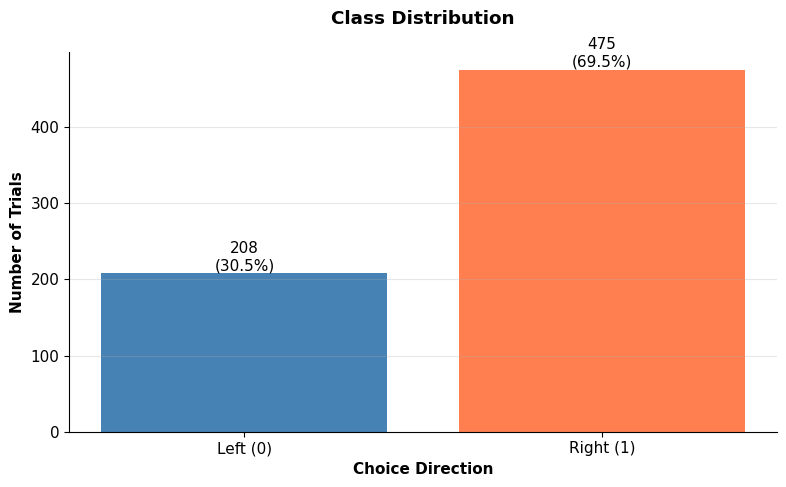

In [46]:
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(['Left (0)', 'Right (1)'], class_counts.values, color=['steelblue', 'coral'])

for bar, count, prop in zip(bars, class_counts.values, class_props.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({prop*100:.1f}%)',
            ha='center', va='bottom')

ax.set_ylabel('Number of Trials', fontweight='bold')
ax.set_xlabel('Choice Direction', fontweight='bold')
ax.set_title('Class Distribution', fontweight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Feature Characteristics

In [47]:
X = data[feature_cols].values
y = data[label_col].values

print(f"  Mean: {X.mean():.3f}")
print(f"  Median: {np.median(X):.3f}")
print(f"  Std: {X.std():.3f}")

zero_count = (X == 0).sum()
sparsity_pct = (zero_count / X.size) * 100
print(f"  Sparsity: {sparsity_pct:.2f}%")

feature_stds = X.std(axis=0)
low_var_threshold = 0.1
low_var_features = (feature_stds < low_var_threshold).sum()
print(f"  Near-zero variance features: {low_var_features} ({low_var_features/n_features*100:.1f}%)")


  Mean: 0.419
  Median: 0.000
  Std: 0.905
  Sparsity: 74.03%
  Near-zero variance features: 1654 (14.8%)


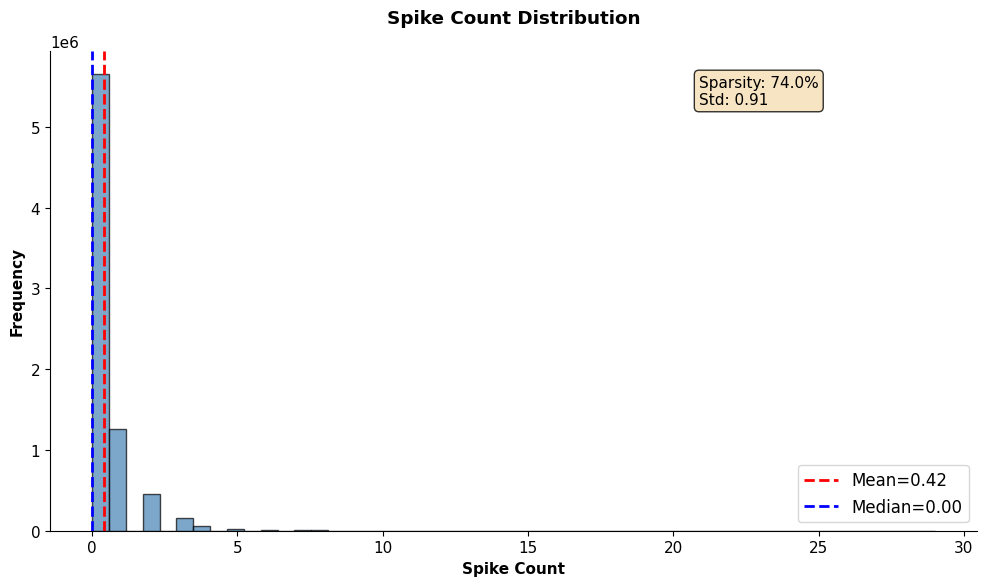


Spike count statistics:
Mean: 0.42
Median: 0.00
Std: 0.91
Min: 0
Max: 29

Percentage of zeros: 74.03%


In [48]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(X.flatten(), bins=50, color= ['steelblue'], alpha=0.7, edgecolor='black')
ax.axvline(X.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={X.mean():.2f}')
ax.axvline(np.median(X), color='blue', linestyle='--', linewidth=2, label=f'Median={np.median(X):.2f}')

textstr = f'Sparsity: {sparsity_pct:.1f}%\nStd: {X.std():.2f}'
ax.text(0.7, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_xlabel('Spike Count', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Spike Count Distribution', fontweight='bold', pad=20)
ax.legend(fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Summary stats
spike_counts = data.iloc[:, 1:].values.flatten()
print("\nSpike count statistics:")
print(f"Mean: {np.mean(spike_counts):.2f}")
print(f"Median: {np.median(spike_counts):.2f}")
print(f"Std: {np.std(spike_counts):.2f}")
print(f"Min: {np.min(spike_counts)}")
print(f"Max: {np.max(spike_counts)}")

# Sparsity
print(f"\nPercentage of zeros: {np.mean(spike_counts == 0) * 100:.2f}%")

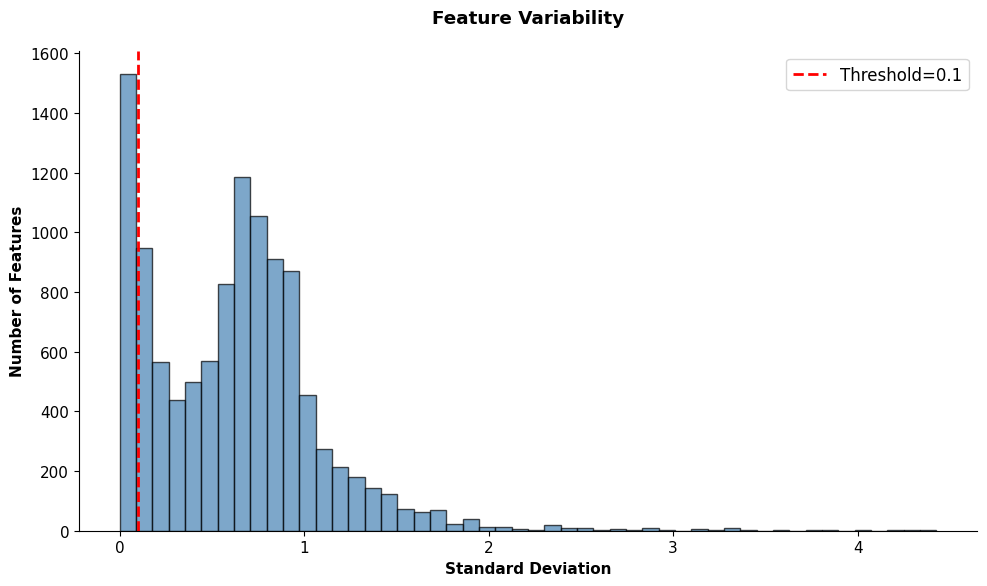

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(feature_stds, bins=50, color= ['steelblue'], alpha=0.7, edgecolor='black')
ax.axvline(low_var_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold={low_var_threshold}')

ax.set_xlabel('Standard Deviation', fontweight='bold')
ax.set_ylabel('Number of Features', fontweight='bold')
ax.set_title('Feature Variability', fontweight='bold', pad=20)
ax.legend(fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Temporal Dynamics

In [ ]:
X_left = X[y == 0]
X_right = X[y == 1]

bin_means_left = np.zeros(n_bins)
bin_means_right = np.zeros(n_bins)
bin_effect_sizes = np.zeros(n_bins)

for bin_idx in range(n_bins):
    bin_features = [i for i, col in enumerate(feature_cols) if f'_bin_{bin_idx}' in col]
    if len(bin_features) > 0:
        bin_means_left[bin_idx] = X_left[:, bin_features].mean()
        bin_means_right[bin_idx] = X_right[:, bin_features].mean()

most_discriminative_bin = np.argmax(bin_effect_sizes)
print(f"  Most discriminative bin: {most_discriminative_bin} ({most_discriminative_bin*100}-{(most_discriminative_bin+1)*100}ms)")
print(f"  Effect size: {bin_effect_sizes[most_discriminative_bin]:.3f}")

  Most discriminative bin: 3 (300-400ms)
  Effect size: 0.101


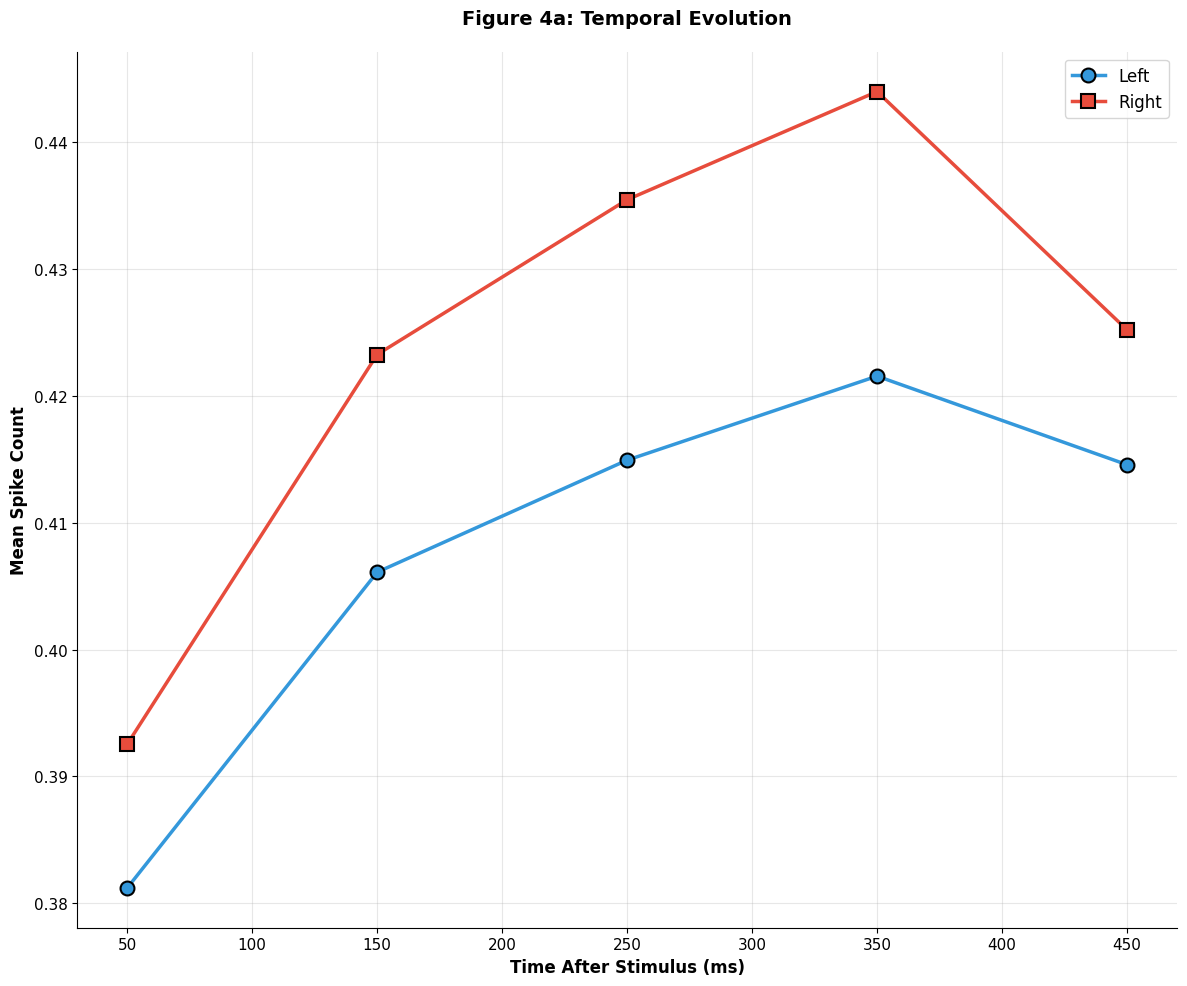

In [65]:
# Figure 4: Temporal Evolution
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 10))

time_points = np.arange(n_bins) * 100 + 50

# Panel 1: Mean activity
ax1.plot(time_points, bin_means_left, 'o-', color='#3498db', linewidth=2.5, 
         markersize=10, label='Left', markeredgecolor='black', markeredgewidth=1.5)
ax1.plot(time_points, bin_means_right, 's-', color='#e74c3c', linewidth=2.5, 
         markersize=10, label='Right', markeredgecolor='black', markeredgewidth=1.5)

ax1.set_xlabel('Time After Stimulus (ms)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Spike Count', fontsize=12, fontweight='bold')
ax1.set_title('Figure 4a: Temporal Evolution', fontsize=14, fontweight='bold', pad=20)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()